In [22]:
%pip install torch torchvision torchaudio
%pip install matplotlib
%pip install tensorboard
%pip install onnx


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import torch
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [24]:
unnormalized_training_dataset = datasets.CIFAR10(
  root="./data",
  train=True,
  download=True,
  transform=T.ToTensor(),
)
unnormalized_test_dataset = datasets.CIFAR10(
  root="./data",
  train=False,
  download=True,
  transform=T.ToTensor(),
)

Files already downloaded and verified
Files already downloaded and verified


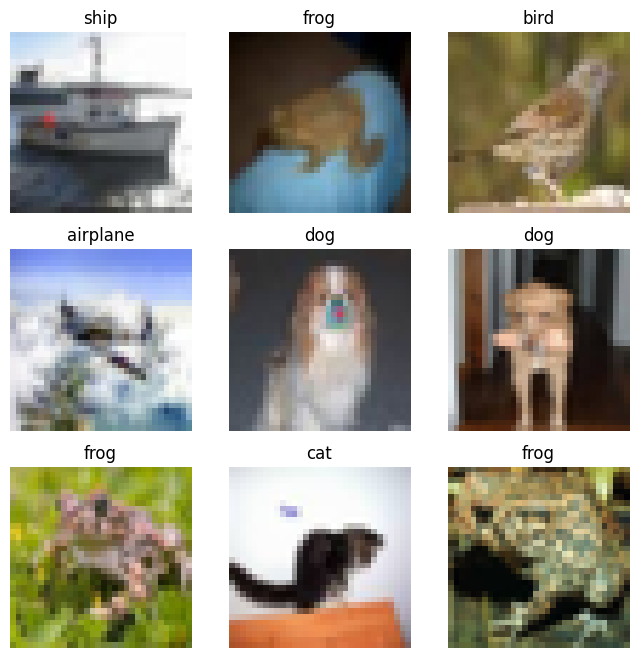

In [25]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(unnormalized_training_dataset), size=(1,)).item()
    img, label = unnormalized_training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())

plt.show()

In [26]:
from torch.utils.data import ConcatDataset

combined_data = ConcatDataset([unnormalized_training_dataset, unnormalized_test_dataset])

mean = 0.
std = 0.
for image, label in combined_data:
    image = image.view(3, -1)
    mean += image.mean(dim=1)
    std += image.std(dim=1)

mean /= len(combined_data)
std /= len(combined_data)

print(f"Mean per channel: {mean}")
print(f"Std per channel: {std}")

Mean per channel: tensor([0.4919, 0.4827, 0.4472])
Std per channel: tensor([0.2023, 0.1994, 0.2010])


In [27]:
training_dataset = datasets.CIFAR10(
  root="./data",
  train=True,
  download=True,
  transform=T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
  ]),
)
test_dataset = datasets.CIFAR10(
  root="./data",
  train=False,
  download=True,
  transform=T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
  ]),
)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2248905..2.7505183].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2045972..2.6919837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3784417..2.5358925].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1468449..2.3798015].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4319634..1.9888556].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3619602..2.7505183].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.412573

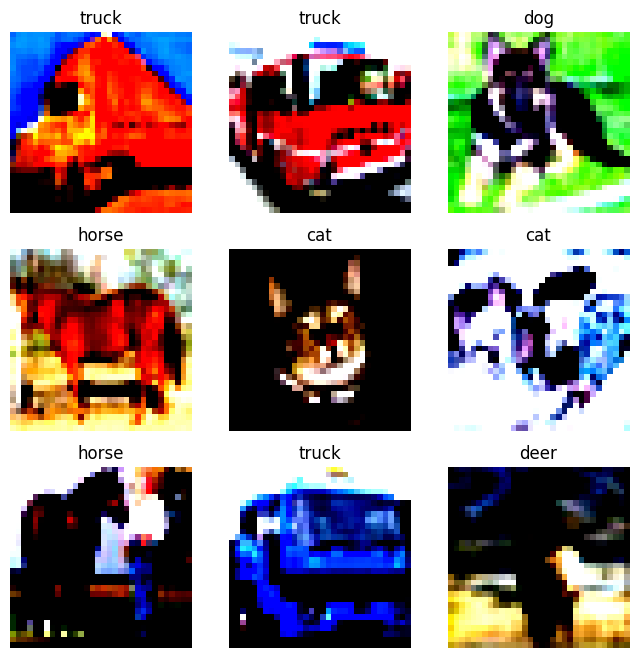

In [28]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())

plt.show()

In [29]:
print(training_dataset)
print(training_dataset.data.shape)

targets = torch.tensor(training_dataset.targets)
print(targets.shape)
print(torch.unique(targets))
print(torch.bincount(targets))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=tensor([0.4919, 0.4827, 0.4472]), std=tensor([0.2023, 0.1994, 0.2010]))
           )
(50000, 32, 32, 3)
torch.Size([50000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])


In [30]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for X, y in test_dataloader:
  print(X.shape, y.shape)
  break

torch.Size([64, 3, 32, 32]) torch.Size([64])


In [31]:
train_features, train_labels = next(iter(train_dataloader))
train_features.shape, train_labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [32]:
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self, dims):
    super(MLP, self).__init__()
    self.fcs = nn.ModuleList(
      [nn.Linear(dims[i], dims[i+1]) for i in range(len(dims)-1)]
    )
    self.act = nn.ReLU()
    self.flatten = nn.Flatten()

  def forward(self, x):
    x = self.flatten(x)
    for layer in self.fcs:
      x = layer(x)
      x = self.act(x)
    return x

In [33]:
input_dim = 32 * 32 * 3
output_dim = 10
model = MLP([input_dim, 512, 256, output_dim])

In [34]:
model

MLP(
  (fcs): ModuleList(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [36]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

model.to(device)
loss_fn.to(device)

Using mps device


CrossEntropyLoss()

In [37]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist_experiment_1')
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    model.train()
    epoch_loss = 0
    correct = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        train_loss, accuracy = train_loop(dataloader_train, model, loss_fn, optimizer, batch_size)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': accuracy}, epoch)

        test_loss, accuracy = test_loop(dataloader_test, model, loss_fn)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': accuracy}, epoch)

        print(f"Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
        print(f"Epoch {epoch+1}/{epochs} complete\n")

In [38]:
epochs = 10
# train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs, batch_size)
# print("Done!")

In [39]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv_stack = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.mlp = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64 * 16 * 16, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

  def forward(self, x):
    x = self.conv_stack(x)
    x = self.mlp(x)
    return x

In [40]:
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3)

In [41]:
train_and_test(train_dataloader, test_dataloader, cnn, loss_fn, optimizer, epochs, batch_size)
print("Done!")

Epoch 1/10
Loss: 0.9863, Accuracy: 65.18%
Epoch 1/10 complete

Epoch 2/10
Loss: 0.8883, Accuracy: 69.34%
Epoch 2/10 complete

Epoch 3/10
Loss: 0.8864, Accuracy: 70.78%
Epoch 3/10 complete

Epoch 4/10
Loss: 1.0926, Accuracy: 70.13%
Epoch 4/10 complete

Epoch 5/10
Loss: 1.2782, Accuracy: 70.80%
Epoch 5/10 complete

Epoch 6/10
Loss: 1.5361, Accuracy: 69.13%
Epoch 6/10 complete

Epoch 7/10
Loss: 1.6147, Accuracy: 69.58%
Epoch 7/10 complete

Epoch 8/10
Loss: 1.8377, Accuracy: 69.39%
Epoch 8/10 complete

Epoch 9/10
Loss: 1.7283, Accuracy: 69.21%
Epoch 9/10 complete

Epoch 10/10
Loss: 1.8460, Accuracy: 69.07%
Epoch 10/10 complete

Done!


In [43]:
cnn.to("cpu")
torch_input = torch.randn(64, 3, 32, 32)
onnx_program = torch.onnx.export(
  cnn,
  torch_input,
  "./app/model.onnx",
  verbose=True,
  input_names=["input"],
  output_names=["output"],
  opset_version=11,
  export_params=True,
  do_constant_folding=True,
  dynamic_axes={
    "input": {0: "batch_size"},
    "output": {0: "batch_size"}
  }
)

Exported graph: graph(%input : Float(*, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu),
      %conv_stack.0.weight : Float(32, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_stack.0.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.2.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_stack.2.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %mlp.1.weight : Float(512, 16384, strides=[16384, 1], requires_grad=1, device=cpu),
      %mlp.1.bias : Float(512, strides=[1], requires_grad=1, device=cpu),
      %mlp.3.weight : Float(256, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %mlp.3.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %mlp.5.weight : Float(10, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %mlp.5.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/conv_stack/conv_stack.0/Conv_output_0 :